In [1]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("Modelling")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
24/08/25 18:05:19 WARN Utils: Your hostname, Bobert resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
24/08/25 18:05:19 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/25 18:05:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols, glm
import sklearn
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

In [3]:
taxi_weather = spark.read.parquet("../data/curated/YellowTaxi_Weather")

In [4]:
# Following code is retrieved from https://towardsdatascience.com/how-to-implement-random-forest-regression-in-pyspark-9582f4964285
# And modified by Can Senyurt

features = 'features'
numerical_cols = ['passenger_count', 'trip_distance', 'fare_amount', 'tolls_amount', 'congestion_surcharge','trip_duration', 'pickup_hour' ,'temp','snow' ,'precip','windspeed','sealevelpressure','cloudcover','visibility','uvindex']
cat_cols = ['PULocationID', 'pickup_day', 'pickup_hour', 'icon']

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder

stages = [] # Stages in Pipeline

for c in cat_cols:
    stringIndexer = StringIndexer(inputCol=c, outputCol=c + "_index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], \
            outputCols=[c + "_vec"])    
    stages += [stringIndexer, encoder] # Stages will be run later on

from pyspark.ml.feature import VectorAssembler

# Transform all features into a vector
assemblerInputs = [c + "_vec" for c in cat_cols] + numerical_cols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

# Create pipeline and use on dataset
combined = numerical_cols + cat_cols
pipeline = Pipeline(stages=stages)
df = taxi_weather.select(combined)
df = df.dropna('any') # Justify, pyspark ml can't handle missing values
df = pipeline.fit(taxi_weather).transform(taxi_weather)

train, test = df.randomSplit([0.8, 0.2], seed=42)

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol='features', labelCol='tip_amount')
rf_model = rf.fit(train)

train_predictions = rf_model.transform(train)
test_predictions = rf_model.transform(test)


24/08/25 18:06:34 WARN MemoryStore: Not enough space to cache rdd_49_16 in memory! (computed 3.5 MiB so far)
24/08/25 18:06:34 WARN BlockManager: Persisting block rdd_49_16 to disk instead.
24/08/25 18:06:43 WARN MemoryStore: Not enough space to cache rdd_49_8 in memory! (computed 166.9 MiB so far)
24/08/25 18:06:43 WARN BlockManager: Persisting block rdd_49_8 to disk instead.
24/08/25 18:06:43 WARN MemoryStore: Not enough space to cache rdd_49_6 in memory! (computed 166.9 MiB so far)
24/08/25 18:06:43 WARN BlockManager: Persisting block rdd_49_6 to disk instead.
24/08/25 18:06:43 WARN MemoryStore: Not enough space to cache rdd_49_9 in memory! (computed 250.9 MiB so far)
24/08/25 18:06:43 WARN BlockManager: Persisting block rdd_49_9 to disk instead.
24/08/25 18:06:43 WARN MemoryStore: Not enough space to cache rdd_49_11 in memory! (computed 250.9 MiB so far)
24/08/25 18:06:43 WARN BlockManager: Persisting block rdd_49_11 to disk instead.
24/08/25 18:06:46 WARN MemoryStore: Not enough s

In [5]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="tip_amount", metricName="rmse")

print("Train RMSE:", evaluator.evaluate(train_predictions))
print("Test RMSE:", evaluator.evaluate(test_predictions))

Train R2: 2.4519288600867077


Test R2: 2.452923943486923


In [6]:
evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="tip_amount", metricName="r2")

print("Train R2:", evaluator.evaluate(train_predictions))
print("Test R2:", evaluator.evaluate(test_predictions))

Train R2: 0.622618797112571


Test R2: 0.6234497260447931


In [7]:
# Linear Regression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StandardScaler

# Fit scaler to train dataset
scaler = StandardScaler().setInputCol('features') \
        .setOutputCol('scaled_features')
scaler_model = scaler.fit(train)

# Scale train and test features
train = scaler_model.transform(train)
test = scaler_model.transform(test)

24/08/25 18:20:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [8]:
lr = LinearRegression(featuresCol='scaled_features', labelCol='tip_amount', elasticNetParam=1)
lr_model = lr.fit(train)

24/08/25 18:20:49 WARN Instrumentation: [4a5b86aa] regParam is zero, which might cause numerical instability and overfitting.
24/08/25 18:20:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/25 18:21:09 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
24/08/25 18:21:09 WARN Instrumentation: [4a5b86aa] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [9]:
train_predictions = lr_model.transform(train)
test_predictions = lr_model.transform(test)

In [10]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="tip_amount", metricName="rmse")

print("Train RMSE:", evaluator.evaluate(train_predictions))
print("Test RMSE:", evaluator.evaluate(test_predictions))


Train RMSE: 2.432516121538103


Test RMSE: 2.431999312186557


In [11]:
evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="tip_amount", metricName="r2")

print("Train R2:", evaluator.evaluate(train_predictions))
print("Test R2:", evaluator.evaluate(test_predictions))

Train R2: 0.6285708469787202


Test R2: 0.6298466378397323


In [25]:
list_extract = []
for i in df.schema['features'].metadata["ml_attr"]["attrs"]:
    list_extract = list_extract + df.schema['features'] \
                    .metadata["ml_attr"]["attrs"][i]
varlist = pd.DataFrame(list_extract)
varlist['weight'] = varlist['idx'].apply(lambda x: lr_model.coefficients[x])
weights = varlist.sort_values('weight', ascending = False)


In [35]:
weights.sort_values('weight', ascending = False).head(20)

,idx,name,weight
2,295,fare_amount,1.778094
1,294,trip_distance,0.689600
3,296,tolls_amount,0.450185
5,298,trip_duration,0.408598
19,4,PULocationID_vec_138,0.277482
4,297,congestion_surcharge,0.166392
60,45,PULocationID_vec_70,0.088258
6,299,pickup_hour,0.048624
282,267,pickup_hour_vec_16,0.040983
279,264,pickup_hour_vec_17,0.038525


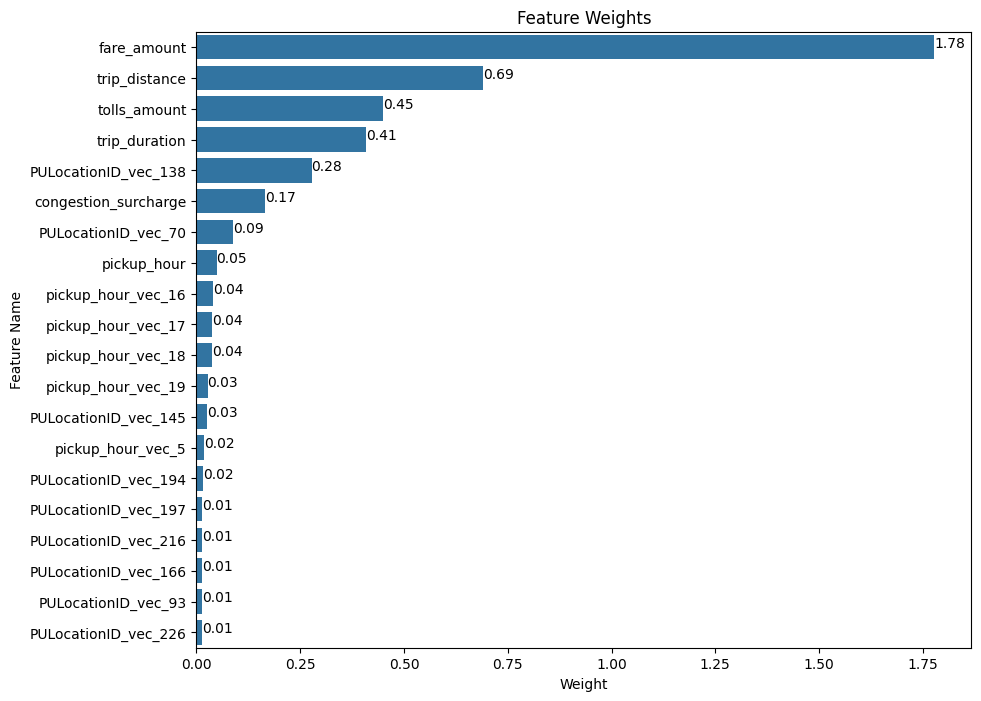

In [46]:
import seaborn as sns
def show_values(axs, space=.01):
    def _single(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
            value = '{:.2f}'.format(p.get_width())
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)
        
def plot_feature_weights(df):
    plt.figure(figsize=(10, 8))
    p = sns.barplot(x=df['weight'], y=df['name'])
    show_values(p, space=0)
    
    plt.title('Feature Weights')
    plt.xlabel('Weight')
    plt.ylabel('Feature Name')
    plt.savefig('../plots/feature_weights.png')

plot_feature_weights(weights.sort_values('weight', ascending = False).head(20))

In [45]:
weights

,idx,name,weight
2,295,fare_amount,1.778094
1,294,trip_distance,0.689600
3,296,tolls_amount,0.450185
5,298,trip_duration,0.408598
19,4,PULocationID_vec_138,0.277482
...,...,...,...
32,17,PULocationID_vec_141,-0.021178
291,276,pickup_hour_vec_23,-0.023897
277,262,pickup_day_vec_Sun,-0.043287
274,259,pickup_day_vec_Sat,-0.052897


In [44]:
zone_lookup = pd.read_csv("../data/raw/TaxiZones/taxi+_zone_lookup.csv")

high_value_zones = [138, 70, 16,17,18]

zone_lookup[zone_lookup['LocationID'].isin(high_value_zones)]

,LocationID,Borough,Zone,service_zone
15,16,Queens,Bayside,Boro Zone
16,17,Brooklyn,Bedford,Boro Zone
17,18,Bronx,Bedford Park,Boro Zone
69,70,Queens,East Elmhurst,Boro Zone
137,138,Queens,LaGuardia Airport,Airports
